In [1]:
%pylab inline
pylab.rcParams['figure.figsize'] = 12,5

Populating the interactive namespace from numpy and matplotlib


Based on the characterization of the Axon-Hillock design performed in AHOsc_Char.ipynb and AHOsc_Optimize.ipynb, we have one good solution for large currents and two possible solutions for small currents.  This notebook will be used to show the final results before we choose a final design to help us debug and optimize these circuits until we have a promising final solution.  Hopefully, once we've optimized these circuits, we will be able to use them for the current proposed ADC (an Analog to Time to Digital Converter, ATDC).

The other more pressing reason for forking this notebook from the previous notebook was to clean up the code and shorten the notebook length.

In [2]:
import os
import sys
from scipy.optimize import leastsq, fsolve
from pylab import *
import csv
import mpld3
from IPython.display import Image
import pandas as pd

# Global Functions and Variables

## Read Functions

In [3]:
sampleTime = 20e-6

#folderPath="/home/noza/work/Braindrop/CDB/BDTests/AHOsc_test/Measurements/"
folderPath="/home/noza/work/data/AHResults/"

# This readFile to takes the average value of every other column
def readFile(filePath):
    data = genfromtxt(filePath, dtype=float, delimiter=",", skip_header=1)
    sampleFreqs = data[:,1::2]
    return nanmean(sampleFreqs, axis=0)

# This file will read the params csv file (saved by the Parametric Analysis tool)
# (In the future make this more generic, with input array set in order of CSV file rows)
def readParams(paramFile):
    for i, row in enumerate(csv.reader(paramFile)):
        if i == 0:
            temps = [int(i) for i in array(row[1:])]
            print "Temps: ", temps
        elif i==1:
            Iins = array(double(row[1:]))
            print "Iins: ", Iins
        else:
            print "Too many rows"
    return temps, Iins

## Get functions

In [4]:
# Getter functions to convert a string to a value for handling units
def getFScaleVal(FScaleFactor):
    if FScaleFactor in ['G', 'GHz']:
        FScale = 1e9
        FLbl = '$F(GHz)$'
    elif FScaleFactor in ['M', 'MHz']:
        FScale = 1e6
        FLbl = '$F(MHz)$'
    elif FScaleFactor in ['K', 'KHz']:
        FScale = 1e3
        FLbl = '$F(KHz)$'
    elif FScaleFactor <= 1:
        FScale = 1
        FLbl = '$F(Hz)$'
    return FScale, FLbl

# Getter functions to convert a string to a value for handling units
def getTScaleVal(TScaleFactor):
    if TScaleFactor in ['n', 'ns']:
        TScale = 1e-9
        TLbl = '$T(ns)$'
    elif TScaleFactor in ['u', 'us']:
        TScale = 1e-6
        TLbl = '$T(\mu s)$'
    elif TScaleFactor in ['m', 'ms']:
        TScale = 1e-3
        TLbl = '$T(ms)$'
    elif TScaleFactor <= 1:
        TScale = 1
        TLbl = '$T(s)$'
    return TScale, TLbl

def getIScaleVal(IScaleFactor):
    if IScaleFactor in ['f', 'fa', 'fA']:
        IScale = 1e-15
        ILbl = '$I_{in} (fA)$'
    elif IScaleFactor in ['p', 'pa', 'pA']:
        IScale = 1e-12
        ILbl = '$I_{in} (pA)$'
    elif IScaleFactor in ['n', 'na', 'nA']:
        IScale = 1e-9
        ILbl = '$I_{in} (nA)$'
    return IScale, ILbl

# This function will return the charging and discharging periods for a given circuit,
# based upon three vectors worth of information.  The first vector (TLs) is the 
# period between the previous numbered falling edge and the given numbered rising edge.
# The second vector (TEs) is the period between the given numbered falling edge 
# and the given numbered rising edge.  The third vector (THs) is the period between
# the next numbered falling edge and the given rising edge.
# Each vector should be of a length equal to the number of input currents swept (N), where
# each period is the period measured at the given input current.
def getPeriodLengths(TLs, TEs, THs):
    #print "Period between Rising5 and Falling 4", TLs
    #print "Period between Rising5 and Falling 5", TEs
    #print "Period between Rising5 and Falling 6", THs
    # Combine all the vectors and transpose to make an Nx3 matrix
    allTs = array([array(TLs), array(TEs), array(THs)]).T
    Tchs = list()
    Tdchs = list()
    for i, curIinsTs in enumerate(allTs):
        #print curIinsTs
        if curIinsTs[1]<0:
            Tchs.append(abs(curIinsTs[1]))
            Tdchs.append(abs(curIinsTs[2]))
        else:
            Tchs.append(abs(curIinsTs[0]))
            Tdchs.append(abs(curIinsTs[1]))
    #print "Charging Periods:", Tchs
    #print "Discharging Periods:", Tdchs
    return Tchs, Tdchs
    

## Fitting Functions

In [5]:
# This function takes a set of data and runs the least squares algorithm using the log10
# fit.  The log10 model is used to fit the relation between frequency and input current
def getLinFitParams(xData, yData):
    sol = leastsq(log10FErr, (1e10, 1e-15), (xData, yData))
    params = sol[0]
    #print "Params:", params
    x_th = linspace(min(xData),max(xData), num=10000)
    y_th = linF(x_th, params)
    return x_th, y_th, params

# This function takes a set of data and runs the least squares algorithm using the log10
# fit.  The log10 model is used to fit the relation between frequency and input current
# Note: It does a non-linear fit using the more complex model of the FI relation
def getNLFitParams(xData, yData):
    sol = leastsq(NLPeriodErr, (10e-9, -5e-7, 4e8, 10e-8), (xData, yData))
    params = sol[0]
    #print "Params:", params
    x_th = linspace(min(xData),max(xData), num=10000)
    y_th = NLPeriod(x_th, params)
    return x_th, y_th, params

def NLF(xData, chParams, dchParams):
    return 1./(NLPeriod(xData,chParams)+NLPeriod(xData,dchParams))

def NLFErr(xData, yData, chParams, dchParams):
    return yData - 1./(NLPeriod(xData,chParams)+NLPeriod(xData,dchParams))
    
def NLPeriod(xData, params):
    # p1 = (C1+C2)*Ut / (gamma2*exp(-Vinv/Ut))
    # p2 = Ilkg / (gamma2*exp(-Vinv/Ut))
    # p3 = gamma1 / (gamma2*exp(-Vinv/Ut))
    # p4 = C2 * Vdd / (gamma2*exp(-Vinv/Ut))
    p1, p2, p3, p4 = params
    #print "Params", params
    preMultiplier = p1 / (p2+p3*xData)
    logNumerator = exp(p4/p1) * (p2+xData*(1+p3))
    logDenominator = p2 + xData*(exp(p4/p1)+p3)
    #print preMultiplier*log(logNumerator/logDenominator)
    return preMultiplier*log(logNumerator/logDenominator)

def log10NLT(xData, params):
    return log10(NLPeriod(xData,params))

def NLPeriodErr(params, xData, yData):
    return log10(yData)-log10NLT(xData,params)

# These functions define the equation used to fit the data points.
def linF(xData, params):
    m, I0 = params
    return m*(xData+I0)

def invLinF(yData, params):
    m, I0 = params
    return yData/m - I0

def linFErr(params, xData, yData):
    m, I0 = params
    #return ydata - (m/(xdata-I0) + b)
    return yData - linfit(xData, params)

# These functions define the equation used to fit the data points.
def log10F(xData, params):
    m, I0 = params
    return log10(m*(xData+I0))

# These functions define the equation used to fit the data points.
def invLog10F(yData, params):
    m, I0 = params
    return log10(yData/m - I0)

def log10FErr(params, xData, yData):
    m, I0 = params
    #print "WHat's up"
    #print log10(ydata)
    #print "Not much"
    #print "xData:", xdata
    #print "Params:", params
    #print logF(xdata, params)
    #print "Ok, have a great day"
    return log10(yData) - log10F(xData, params)

## List-based Functions

In [6]:
def elementWiseAvg(lst):
    avglst = array([((lst[i]+lst[i+1])/2.) for i, curElement in enumerate(lst[:-1])])
    #print "AVG list: ", avglst
    return avglst

def rejectOutliers(data, m = 2.):
    dat = array(data)
    d = np.abs(dat - np.median(dat))
    mdev = np.median(d)
    s = d/mdev if mdev else 0.
    #print d, '\n',mdev,'\n', s, '\n', map(int, round(s)), '\n', s<m
    return dat[s<m], s<m

## Plot Functions

In [7]:
def setAxis(ax=None):
    # If no axis is explicitly sent, use the current axis
    if ax==None:
        curAxis = gca()
        #print "No Axis found using current axis in memory", curAxis
    else:
        curAxis = ax
        sca(ax)
    #sca(curAxis)
    return curAxis
        
def setXLim(Xs, xLims=None, minScale=0.9, maxScale=1.1, ax=None):
    setAxis(ax)
    sca(ax)
    if type(xLims)==str:
        if xLims=="N":
            xlim(Xs.min()*minScale, 0)
        elif xLims=="P":
            xlim(0, Xs.max()*maxScale)
        elif xLims=='NP' or xLims=='PN':
            xlim(Xs.min()*minScale, Xs.max()*maxScale)
    elif type(xLims)==tuple:
        xlim(xLims)

def setYLim(Ys, yLims=None, minScale=0.9, maxScale=1.1, ax=None):
    setAxis(ax)
    sca(ax)
    if type(yLims)==str:
        if yLims=="N":
            ylim(Ys.min()*minScale, 0)
        elif yLims=="P":
            ylim(0, Ys.max()*maxScale)
        elif yLims=='NP' or yLims=='PN':
            ylim(Ys.min()*minScale, Ys.max()*maxScale)
    elif type(yLims)==tuple:
        ylim(yLims)
    
def plotXY(Xs, Ys, marker='.', lineStyle='', ttl="Y vs X", xLbl="X", yLbl="Y", pltLbl=None,
           color=(1,0,0), fntSz=16, xLims=None, yLims=None, ax=None):
    ax = setAxis(ax)
    # Determine whether or not there are multiple columns worth of (x,y) plots.
    # If so, color code the plots from blue to red, otherwise, use the input color
    if len(shape(Ys))>1 and shape(Ys)[1]>1:
        numCols = shape(Ys)[1]
        for i in range(numCols):
            ax.plot(Xs, Ys.T[i], marker=marker, linestyle=lineStyle, label=pltLbl, 
                    color=(1.*i/(numCols-1), 0, 1.-(1.*i/(numCols-1))))
    else:
        ax.plot(Xs, Ys, marker=marker, linestyle=lineStyle, label=pltLbl, color=color)
    sca(ax)
    xlabel(xLbl, fontsize=fntSz)
    ylabel(yLbl, fontsize=fntSz)
    setXLim(Xs, xLims, minScale=0.9, maxScale=1.1, ax=ax)
    setYLim(Ys, yLims, minScale=0.9, maxScale=1.1, ax=ax)
    title(ttl, fontsize=fntSz-4)

def plotXlogY(Xs, Ys, marker='.', lineStyle='', ttl="Log[Y] vs X", xLbl="X", yLbl="Log[Y]", pltLbl=None,
              color=(1,0,0), fntSz=16, xLims=None, yLims=None, ax=None):
    ax = setAxis(ax)
    # Determine whether or not there are multiple columns worth of (x,y) plots.
    # If so, color code the plots from blue to red, otherwise, use the input color
    if len(shape(Ys))>1 and shape(Ys)[1]>1:
        numCols = shape(Ys)[1]
        for i in range(numCols):
            ax.semilogy(Xs, Ys.T[i], marker=marker, linestyle=lineStyle, label=pltLbl, 
                        color=(1.*i/(numCols-1), 0, 1.-(1.*i/(numCols-1))))
    else:
        ax.semilogy(Xs, Ys, marker=marker, linestyle=lineStyle, label=pltLbl, color=color)
    sca(ax)
    xlabel(xLbl, fontsize=fntSz)
    ylabel(yLbl, fontsize=fntSz)
    setXLim(Xs, xLims, minScale=0.1, maxScale=10, ax=ax)
    setYLim(Ys, yLims, minScale=0.1, maxScale=10, ax=ax)
    title(ttl, fontsize=fntSz-4)

def plotlogXlogY(Xs, Ys, marker='.', lineStyle='', ttl="Log[Y] vs Log[X]", xLbl="Log[X]", yLbl="Log[Y]",
                 pltLbl=None, color=(1,0,0), fntSz=16, xLims=None, yLims=None, ax=None):
    ax = setAxis(ax)
    # Determine whether or not there are multiple columns worth of (x,y) plots.
    # If so, color code the plots from blue to red, otherwise, use the input color
    if len(shape(Ys))>1 and shape(Ys)[1]>1:
        numCols = shape(Ys)[1]
        for i in range(numCols):
            ax.loglog(Xs, Ys.T[i], marker=marker, linestyle=lineStyle, label=pltLbl, 
                      color=(1.*i/(numCols-1), 0, 1.-(1.*i/(numCols-1))))
    else:
        ax.loglog(Xs, Ys, marker=marker, linestyle=lineStyle, label=pltLbl, color=color)
    sca(ax)
    xlabel(xLbl, fontsize=fntSz)
    ylabel(yLbl, fontsize=fntSz)
    setXLim(Xs, xLims, minScale=0.1, maxScale=10, ax=ax)
    setYLim(Ys, yLims, minScale=0.1, maxScale=10, ax=ax)
    title(ttl, fontsize=fntSz-4)

# This function plots the derivative of any data set.
def plotDeriv(Xs, Ys, marker='.', lineStyle='', ttl="dY/dX vs X", xLbl='X', yLbl='dY/dX', pltLbl=None,
              color=(1,0,0), fntSz=16, xLims=None, yLims=None, ax=None):
    ax = setAxis(ax)
    dYs = diff(Ys)
    dXs = diff(Xs)
    ax.plot(elementWiseAvg(Xs), dYs/dXs, marker=marker, linestyle=lineStyle, label=pltLbl, color=color)
    sca(ax)
    xlabel(xLbl, fontsize=fntSz)
    ylabel(yLbl, fontsize=fntSz)
    setXLim(Xs, xLims, minScale=0.9, maxScale=1.1, ax=ax)
    setYLim(dYs, yLims, minScale=0.9, maxScale=1.1, ax=ax)
    title(ttl, fontsize=fntSz-4)
    return dYs/dXs

# Plot a histogram of the gmOverId values to see what value I should be using for my maximum
def plotHist(Xs, numBins=100, ttl=r'$Histogram$', color=(1,0,0),
             xLbl=r'Xs', yLbl=r'Count', pltLbl=None, fntSz=16, ax=None):
    ax = setAxis(ax)
    # Determine whether or not there are multiple columns worth of (x,y) plots.
    # If so, color code the plots from blue to red, otherwise, use the input color
    if len(shape(Xs))>1 and shape(Xs)[1]>1:
        numCols = shape(Xs)[1]
        for i in range(numCols):
            ax.hist(Xs.T[i], bins=numBins, label=pltLbl, 
                    color=(1.*i/(numCols-1), 0, 1.-(1.*i/(numCols-1))), alpha=0.5,
                    histtype="stepfilled")
    else:
        ax.hist(Xs, bins=numBins, label=pltLbl, color=color, alpha=0.5, histtype="stepfilled")    
    (cnts, binBoundaries) = histogram(Xs, numBins)
    sca(ax)
    xlabel(xLbl, fontsize=fntSz)
    ylabel(yLbl, fontsize=fntSz)
    ylim([cnts.min(), cnts.max()*1.1])
    title(ttl)
    return cnts, binBoundaries

In [62]:
# Plot T (period) vs 1/Iin (inverse input current)   
def plotFI(Iins, Fs, curTemp, Is_th, Fs_th, col=(1,0,0),
           xLbl='$I_{in}$',yLbl='$F$', IScaleFactor='nA', FScaleFactor='MHz'):
    FScale, FLbl = getFScaleVal(FScaleFactor)
    IScale, ILbl = getIScaleVal(IScaleFactor)

    subplot(1,3,1)
    # Plot on a linear scale
    plotXY(Iins/IScale, Fs/FScale, marker = '.', lineStyle='', ttl='Osc Freq',
           xLbl=ILbl, yLbl=FLbl, pltLbl=str(curTemp)+"C", color=col)
    plot(Is_th/IScale, Fs_th/FScale, '--', color=col)
    
    subplot(1,3,2)
    # Plot log values on a linear scale
    logXVals = log10(Iins)
    logYVals = log10(Fs)
    plotXY(logXVals, logYVals, marker='.', lineStyle='', ttl='Log10 Osc Freq',
           xLbl=r'$log_{10}$('+xLbl+')', yLbl=r'$log_{10}$('+yLbl+')', pltLbl=str(curTemp)+"C", color=col)
    # Plot the model fit over the data
    plot(log10(Is_th), log10(Fs_th), '--', color=col)
    
    subplot(1,3,3)
    # Plot the derivative of the FI Curve
    plotDeriv(Iins, Fs, marker='', lineStyle='-', ttl='Derivative of Osc Freq',
            xLbl=xLbl, yLbl='$\\frac{dF}{dI_{in}}$', pltLbl=str(curTemp)+"C", color=col)
    
def plotErrDist(genIREs, numBins=10, color=(1,0,0)):
    numRows = ceil(len(genIREs.T) / 4.)
    for i, curIREs in enumerate(genIREs.T):
        #print curIREs
        subplot(numRows,4,i+1)
        plotHist(curIREs*100, numBins=numBins, color=color, xLbl='Rel. Err (%)', yLbl='#')
    tight_layout()

def plotErrDistByTemp(errByTemp, numBins=10):
    allTemps = errByTemp.keys()
    maxTemp = max(allTemps)
    minTemp = min(allTemps)
    for curTemp in allTemps:
        plotErrDist(errByTemp[curTemp], numBins=numBins, 
                    color=(1.*(curTemp-minTemp)/(maxTemp-minTemp), 0, 1.-((curTemp-minTemp)/(maxTemp-minTemp))))

## Calc Functions

### Original FI FIt Function

In [ ]:
def FIFit(paramFileName, dataFileNamePrefix, dataFileNameSuffix, IScaleFactor='nA', FScaleFactor='MHz'):
    allFs = []
    allParams = []
    #globalLims = [0,0]
    #derivLims = [0,1e18,0]

    temps, Iins = readParams(open(folderPath+paramFileName))
    for curTemp in sorted(temps):
        # Determine Color Value
        curTempScale = (float(curTemp)-min(temps))/(max(temps)-min(temps))
        col = (curTempScale,0,1-curTempScale)
        
        fileName = dataFileNamePrefix+str(curTemp)+dataFileNameSuffix
        print fileName
        filePath = folderPath+fileName
        curFs = array(readFile(filePath))
        x_th, Fs_th, curFitParams = getFitParams(Iins, curFs)
        plotFI(Iins, curFs, curTemp, x_th, Fs_th, col,
               IScaleFactor=IScaleFactor, FScaleFactor=FScaleFactor)
        
        allFs.append(curFs)
        allParams.append(curFitParams)
    legend(loc='best')
    tight_layout()
    
    genParams = allParams[int(floor((len(allParams)-1)/2))]
    print '\nGeneral Params: {}'.format(genParams)
    for i, curTemp in enumerate(sorted(temps)):
        print 'Temp: {}-------------'.format(curTemp)
        print 'Temp-Specific Params: {}'.format(allParams[i])
        curFs = allFs[i]
        
        #genAvgFRE, genAvgLogFRE, Fs, thFs, logFs, logThFs = calcRE(Iins, curFs, allParams[i], IScaleFactor=IScaleFactor,
        #                  printREbyIin=True, printRawData=False)
        FREInfo = calcRE(Iins, curFs, genParams, IScaleFactor=IScaleFactor,
                          printREbyIin=True, printRawData=False)
        genAvgFRE, genAvgLogFRE, genFREs, genLogFREs, Fs, thFs, logFs, logThFs = FREInfo
        #genAvgIRE, genAvgLogIRE, Is, thIs, logIs, logThIs  = calcIRE(Iins, curFs, allParams[i], IScaleFactor=IScaleFactor, 
        #                   printREbyIin=True, printRawData=False)
        IREInfo = calcIRE(Iins, curFs, genParams, IScaleFactor=IScaleFactor, 
                           printREbyIin=True, printRawData=False)
        genAvgIRE, genAvgLogIRE, genIREs, genLogIREs, Is, thIs, logIs, logThIs = IREInfo
        #print 'Temp: {}\tRelative RMSE: {:%}\tAvg Rel Err: {:%}'.format(curTemp, RRMSE, spAvgRE)
        #print 'Temp: {}\tAvg General Rel Err: {:%}\n'.format(curTemp, genAvgRE)

    FsAsFuncOfIin = array(allFs).T
    print "Freq Matrix:(Iin x Temp)\n", FsAsFuncOfIin
    percVariancebyTemp(FsAsFuncOfIin, Iins, IScaleFactor=IScaleFactor)
    #mpld3.display()    # Display the plots in interactive mode

### Linear FI FIt Function for Monte Carlo data

In [12]:
#Perform very similar analysis to the FIFit function, but with Monte-Carlo data
def FIFitLinMC(filePath, IScaleFactor='nA', FScaleFactor='MHz', cktPlotList=None, PTAT=False):
    MC_df = pd.read_csv(filePath)
    grouped = MC_df.groupby(['Point','temperature'])
    #print grouped.groups
    #print len(grouped)
    numTemps = len(MC_df.groupby('temperature'))
    minTemp = min(MC_df.groupby('temperature'))[0]
    tempRange = (max(MC_df.groupby('temperature'))[0])-(min(MC_df.groupby('temperature'))[0])
    genParams = dict()
    allParams = dict()

    # Evaluate all monte carlo variants for the extracted parameters
    for name, group in grouped:
        cktNum = name[0]
        curTemp = name[1]
        if cktNum not in allParams.keys():
            allParams[cktNum] = dict()
        #print('Ckt: {}\tTemp: {}'.format(cktNum, curTemp))
        #print(group.loc[:,['Iin','freqVout']])
        curIins = array(group['Iin'])
        if PTAT:
            curIins = curIins*(273.15+curTemp)/298.15
        curFs = array(group['freqVout'])

        # Determine Color Value
        #print (name[0]%255)/255.
        curTempScale = (float(curTemp)-minTemp)/tempRange
        col = (curTempScale,(float(cktNum)%255)/255,1-curTempScale,1)

        x_th, Fs_th, curFitParams = getLinFitParams(curIins, curFs)
        if cktNum in flatten([cktPlotList]):
            print curFitParams
        allParams[cktNum][curTemp] = curFitParams
        if curTemp==25:
            genParams[cktNum] = curFitParams
        if cktPlotList==None:
            plotFI(curIins, curFs, curTemp, x_th, Fs_th, col,
                   IScaleFactor=IScaleFactor, FScaleFactor=FScaleFactor)
        elif cktNum in flatten([cktPlotList]):
            plotFI(curIins, curFs, curTemp, x_th, Fs_th, col,
                   IScaleFactor=IScaleFactor, FScaleFactor=FScaleFactor)
    tight_layout()

    # Calculate the relative error in frequency or input current
    MC_GenIREs = list()
    GenErrbyTemp = dict()
    #print 
    
    curCktFs = list()
    cktNumOld = 1
    for name, group in grouped:
        cktNum = name[0]
        curTemp = name[1]
        if curTemp not in GenErrbyTemp.keys():
            GenErrbyTemp[curTemp] = list()
        if cktNumOld in flatten([cktPlotList]) and cktNum!=cktNumOld:
            print "Freq Matrix:(Iin x Temp)\n", array(curCktFs).T
            percVariancebyTemp(array(curCktFs).T, curIins, IScaleFactor=IScaleFactor)
            cktNumOld = cktNum
            curCktFs = list()
        
        curIins = array(group['Iin'])
        if PTAT:
            curIins = curIins*(273.15+curTemp)/298.15
        curFs = array(group['freqVout'])
        
        if cktNum in flatten([cktPlotList]):
            print('Ckt: {}\tTemp: {}'.format(cktNum, curTemp))
        
            print genParams[cktNum]
            #REInfo = calcLinRE(curIins, curFs, allParams[cktNum][curTemp], IScaleFactor=IScaleFactor,
            #                  printREbyIin=True, printRawData=False)
            #REInfo = calcLinRE(curIins, curFs, genParams[cktNum], IScaleFactor=IScaleFactor,
            #                  printREbyIin=True, printRawData=False)
            #genAvgFRE, genAvgLogFRE, Fs, genREs, genLogREs, thFs, logFs, logThFs = REInfo
            #IREInfo = calcIRE(curIins, curFs, allParams[cktNum][curTemp], IScaleFactor=IScaleFactor, 
            #                   printREbyIin=True, printRawData=False)
            IREInfo = calcLinIRE(curIins, curFs, genParams[cktNum], IScaleFactor=IScaleFactor, 
                               printREbyIin=True, printRawData=False)
            curCktFs.append(curFs)
        else:
            IREInfo = calcLinIRE(curIins, curFs, genParams[cktNum], IScaleFactor=IScaleFactor, 
                               printREbyIin=False, printRawData=False)
        
        genAvgIRE, genAvgLogIRE, genIREs, genLogIREs, Is, thIs, logIs, logThIs = IREInfo
        MC_GenIREs.append(abs(genIREs))
        GenErrbyTemp[curTemp].append(abs(genIREs))
        #print "Max Error: {:%}".format(max(abs(genIREs)))
        #print "Max Log Error: {:%}".format(max(abs(genLogIREs)))
    #print array(MC_GenIREs)
    for key in GenErrbyTemp.keys():
        GenErrbyTemp[key] = array(GenErrbyTemp[key])
        #print GenErrbyTemp[key]
    #print genParams
    print "Iins:", unique(MC_df.Iin)
    print "Max Error by Iin(%):", amax(array(MC_GenIREs),axis=0)*100
    print "Mean Error by Iin(%):", mean(array(MC_GenIREs),axis=0)*100
    return array(MC_GenIREs), GenErrbyTemp


### Non-Linear FI FIt Function

In [9]:
#Perform very similar analysis to the FIFit function, but with Monte-Carlo data
# Also no longer try to fit the FI curve to a linear fit, but instead fit to a
# more complex non-linear model.
def FIFitMC(filePath, IScaleFactor='nA', FScaleFactor='MHz', cktPlotList=None, PTAT=False):
    MC_df = pd.read_csv(filePath)
    grouped = MC_df.groupby(['Point','temperature'])
    #print grouped.groups
    #print len(grouped)
    numTemps = len(MC_df.groupby('temperature'))
    minTemp = min(MC_df.groupby('temperature'))[0]
    tempRange = (max(MC_df.groupby('temperature'))[0])-(min(MC_df.groupby('temperature'))[0])
    genParams = dict()
    allParams = dict()

    # Evaluate all monte carlo variants for the extracted parameters
    for name, group in grouped:
        cktNum = name[0]
        curTemp = name[1]
        if cktNum not in allParams.keys():
            allParams[cktNum] = dict()
        #print('Ckt: {}\tTemp: {}'.format(cktNum, curTemp))
        #print(group.loc[:,['Iin','freqVout']])
        curIins = array(group['Iin'].astype('float32'))
        if PTAT:
            curIins = curIins*(273.15+curTemp)/298.15
        curFs = array(group['freqVout'].astype('float32'))
        
        curTLs = array(group['TF4R5'].astype('float32'))
        curTEs = array(group['TF5R5'].astype('float32'))
        curTHs = array(group['TF6R5'].astype('float32'))
        curTchs, curTdchs = getPeriodLengths(curTLs, curTEs, curTHs)

        # Determine Color Value
        curTempScale = (float(curTemp)-minTemp)/tempRange
        col = (curTempScale,(float(cktNum)%255)/255,1-curTempScale,1)

        #x_th, Fs_th, curFitParams = getLinFitParams(curIins, curFs)
        x_th, Tchs_th, curChFitParams = getNLFitParams(curIins, curTchs)
        x_th, Tdchs_th, curDchFitParams = getNLFitParams(curIins, curTdchs)
        #if cktNum in flatten([cktPlotList]):
        #    print('Ckt: {}\tTemp: {}'.format(cktNum, curTemp))
        #    print "Ch Params:", curChFitParams
        #    print "Dch Params:", curDchFitParams
        allParams[cktNum][curTemp] = curChFitParams, curDchFitParams
        if curTemp==25:
            genParams[cktNum] = curChFitParams, curDchFitParams
        #print Tchs_th
        #print Tdchs_th
        #print (Tchs_th+Tdchs_th)
        Fs_th = 1./(Tchs_th+Tdchs_th)
        
        if cktPlotList==None:
            plotFI(curIins, curFs, curTemp, x_th, Fs_th, col,
                   IScaleFactor=IScaleFactor, FScaleFactor=FScaleFactor)
        elif cktNum in flatten([cktPlotList]):
            plotFI(curIins, curFs, curTemp, x_th, Fs_th, col,
                   IScaleFactor=IScaleFactor, FScaleFactor=FScaleFactor)
    tight_layout()

    # Calculate the relative error in frequency or input current
    MC_GenIREs = list()
    GenErrbyTemp = dict()
    print 
    
    curCktFs = list()
    cktNumOld = 1
    for name, group in grouped:
        cktNum = name[0]
        curTemp = name[1]
        if curTemp not in GenErrbyTemp.keys():
            GenErrbyTemp[curTemp] = list()
        if cktNumOld in flatten([cktPlotList]) and cktNum!=cktNumOld:
            print "Freq Matrix:(Iin x Temp)\n", array(curCktFs).T
            percVariancebyTemp(array(curCktFs).T, curIins, IScaleFactor=IScaleFactor)
            cktNumOld = cktNum
            curCktFs = list()

        curIins = array(group['Iin'])
        if PTAT:
            curIins = curIins*(273.15+curTemp)/298.15
        curFs = array(group['freqVout'])
        
        if cktNum in flatten([cktPlotList]):
            print('Ckt: {}\tTemp: {}'.format(cktNum, curTemp))
            curChParams, curDchParams = genParams[cktNum]
            print "Using these params to fit the data"
            print "\tCh Params:", curChParams
            print "\tDch Params:", curDchParams
        
            #REInfo = calcNLRE(curIins, curFs, allParams[cktNum][curTemp], IScaleFactor=IScaleFactor,
            #                  printREbyIin=True, printRawData=False)
            #REInfo = calcNLRE(curIins, curFs, genParams[cktNum], IScaleFactor=IScaleFactor,
            #                  printREbyIin=True, printRawData=True)
            #genAvgFRE, genAvgLogFRE, Fs, genREs, genLogREs, thFs, logFs, logThFs = REInfo
            #print "Residual Error with fit params for this data"
            #IREInfo = calcNLIRE(curIins, curFs, allParams[cktNum][curTemp], IScaleFactor=IScaleFactor, 
            #                   printREbyIin=True, printRawData=False)
            print "Residual Error with fit params from room temp"
            IREInfo = calcNLIRE(curIins, curFs, genParams[cktNum], IScaleFactor=IScaleFactor, 
                               printREbyIin=True, printRawData=False)
            curCktFs.append(curFs)
        else:
            IREInfo = calcNLIRE(curIins, curFs, genParams[cktNum], IScaleFactor=IScaleFactor, 
                               printREbyIin=False, printRawData=False)
        
        genAvgIRE, genIREs, Is, thIs = IREInfo
        MC_GenIREs.append(abs(genIREs))
        GenErrbyTemp[curTemp].append(abs(genIREs))
        #print "Max Error: {:%}".format(max(abs(genIREs)))
    #print array(MC_GenIREs)
    for key in GenErrbyTemp.keys():
        GenErrbyTemp[key] = array(GenErrbyTemp[key])
        #print GenErrbyTemp[key]
    #print genParams
    print "Iins:", unique(MC_df.Iin)
    print "Max Error by Iin(%):", amax(array(MC_GenIREs),axis=0)*100
    print "Mean Error by Iin(%):", mean(array(MC_GenIREs),axis=0)*100
    return array(MC_GenIREs), GenErrbyTemp

### Non-Linear FI FIt Function separated by Corner-Type

In [54]:
#Perform very similar analysis to the FIFit function, but with Monte-Carlo data
# Also no longer try to fit the FI curve to a linear fit, but instead fit to a
# more complex non-linear model.
def FIFitMCCorners(filePath, IScaleFactor='nA', FScaleFactor='MHz', cktPlotList=None, PTAT=False, corner='TT'):
    MC_df = pd.read_csv(filePath)
    print "Cur Corner: ", corner
    # Set MC_df to the filtered version of the original based on what corner is being evaluated.
    MC_df = MC_df[MC_df['Corner'].str.contains(corner)]
    #print MC_df
    grouped = MC_df.groupby(['Point','temperature'])
    #print grouped.groups
    #print len(grouped)
    numTemps = len(MC_df.groupby('temperature'))
    minTemp = min(MC_df.groupby('temperature'))[0]
    tempRange = (max(MC_df.groupby('temperature'))[0])-(min(MC_df.groupby('temperature'))[0])
    genParams = dict()
    allParams = dict()

    # Evaluate all monte carlo variants for the extracted parameters       
    for name, group in grouped:
        cktNum = name[0]
        curTemp = name[1]

        if cktNum not in allParams.keys():
            allParams[cktNum] = dict()
        #print('Ckt: {}\tTemp: {}'.format(cktNum, curTemp))
        #print(group.loc[:,['Iin','freqVout']])
        curIins = array(group['Iin'].astype('float32'))
        if PTAT:
            curIins = curIins*(273.15+curTemp)/298.15
        curFs = array(group['freqVout'].astype('float32'))

        curTLs = array(group['TF4R5'].astype('float32'))
        curTEs = array(group['TF5R5'].astype('float32'))
        curTHs = array(group['TF6R5'].astype('float32'))
        curTchs, curTdchs = getPeriodLengths(curTLs, curTEs, curTHs)

        # Determine Color Value
        curTempScale = (float(curTemp)-minTemp)/tempRange
        col = (curTempScale,(float(cktNum)%255)/255,1-curTempScale,1)

        #x_th, Fs_th, curFitParams = getLinFitParams(curIins, curFs)
        x_th, Tchs_th, curChFitParams = getNLFitParams(curIins, curTchs)
        x_th, Tdchs_th, curDchFitParams = getNLFitParams(curIins, curTdchs)
        #if cktNum in flatten([cktPlotList]):
        #    print('Ckt: {}\tTemp: {}'.format(cktNum, curTemp))
        #    print "Ch Params:", curChFitParams
        #    print "Dch Params:", curDchFitParams
        allParams[cktNum][curTemp] = curChFitParams, curDchFitParams
        if curTemp==25:
            genParams[cktNum] = curChFitParams, curDchFitParams
        #print Tchs_th
        #print Tdchs_th
        #print (Tchs_th+Tdchs_th)
        Fs_th = 1./(Tchs_th+Tdchs_th)

        if cktPlotList==None:
            plotFI(curIins, curFs, curTemp, x_th, Fs_th, col,
                   IScaleFactor=IScaleFactor, FScaleFactor=FScaleFactor)
        elif cktNum in flatten([cktPlotList]):
            plotFI(curIins, curFs, curTemp, x_th, Fs_th, col,
                   IScaleFactor=IScaleFactor, FScaleFactor=FScaleFactor)
    tight_layout()

    # Calculate the relative error in frequency or input current
    MC_GenIREs = list()
    GenErrbyTemp = dict()
    print 
    
    curCktFs = list()
    cktNumOld = 1
    for name, group in grouped:
        cktNum = name[0]
        curTemp = name[1]
        if curTemp not in GenErrbyTemp.keys():
            GenErrbyTemp[curTemp] = list()
        if cktNumOld in flatten([cktPlotList]) and cktNum!=cktNumOld:
            print "Freq Matrix:(Iin x Temp)\n", array(curCktFs).T
            percVariancebyTemp(array(curCktFs).T, curIins, IScaleFactor=IScaleFactor)
            cktNumOld = cktNum
            curCktFs = list()

        curIins = array(group['Iin'])
        if PTAT:
            curIins = curIins*(273.15+curTemp)/298.15
        curFs = array(group['freqVout'])
        
        if cktNum in flatten([cktPlotList]):
            print('Ckt: {}\tTemp: {}'.format(cktNum, curTemp))
            curChParams, curDchParams = genParams[cktNum]
            print "Using these params to fit the data"
            print "\tCh Params:", curChParams
            print "\tDch Params:", curDchParams
        
            #REInfo = calcNLRE(curIins, curFs, allParams[cktNum][curTemp], IScaleFactor=IScaleFactor,
            #                  printREbyIin=True, printRawData=False)
            #REInfo = calcNLRE(curIins, curFs, genParams[cktNum], IScaleFactor=IScaleFactor,
            #                  printREbyIin=True, printRawData=True)
            #genAvgFRE, genAvgLogFRE, Fs, genREs, genLogREs, thFs, logFs, logThFs = REInfo
            #print "Residual Error with fit params for this data"
            #IREInfo = calcNLIRE(curIins, curFs, allParams[cktNum][curTemp], IScaleFactor=IScaleFactor, 
            #                   printREbyIin=True, printRawData=False)
            print "Residual Error with fit params from room temp"
            IREInfo = calcNLIRE(curIins, curFs, genParams[cktNum], IScaleFactor=IScaleFactor, 
                               printREbyIin=True, printRawData=False)
            curCktFs.append(curFs)
        else:
            IREInfo = calcNLIRE(curIins, curFs, genParams[cktNum], IScaleFactor=IScaleFactor, 
                               printREbyIin=False, printRawData=False)
        
        genAvgIRE, genIREs, Is, thIs = IREInfo
        MC_GenIREs.append(abs(genIREs))
        GenErrbyTemp[curTemp].append(abs(genIREs))
        #print "Max Error: {:%}".format(max(abs(genIREs)))
    #print array(MC_GenIREs)
    for key in GenErrbyTemp.keys():
        GenErrbyTemp[key] = array(GenErrbyTemp[key])
        #print GenErrbyTemp[key]
    #print genParams
    print "Iins:", unique(MC_df.Iin)
    print "Max Error by Iin(%):", amax(array(MC_GenIREs),axis=0)*100
    print "Mean Error by Iin(%):", mean(array(MC_GenIREs),axis=0)*100
    return array(MC_GenIREs), GenErrbyTemp

### Test Code

Cur Corner:  TT

Iins: [  1.00000000e-12   3.16200000e-12   1.00000000e-11   3.16200000e-11
   1.00000000e-10   3.16200000e-10   1.00000000e-09]
Max Error by Iin(%): [ 2.18685675  3.23875472  3.59329701  2.89300051  1.60608394  2.41013752
  5.82132932]
Mean Error by Iin(%): [ 0.98197273  1.88822143  1.99556797  1.270558    0.26010118  1.2348212
  3.2544467 ]


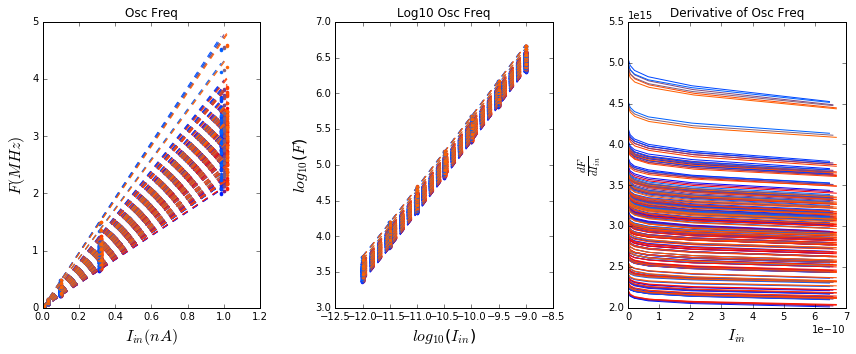

Mean error by Iin at 20C(%): [ 1.06154959  1.99639849  2.15658026  1.44836065  0.42784353  1.06182499
  3.09754187]
Mean error by Iin at 25C(%): [ 0.98340784  1.88305256  1.99545614  1.26876629  0.1694123   1.23320391
  3.25311374]
Mean error by Iin at 30C(%): [ 0.90096075  1.78521324  1.83466749  1.09454707  0.18304771  1.4094347
  3.41268448]


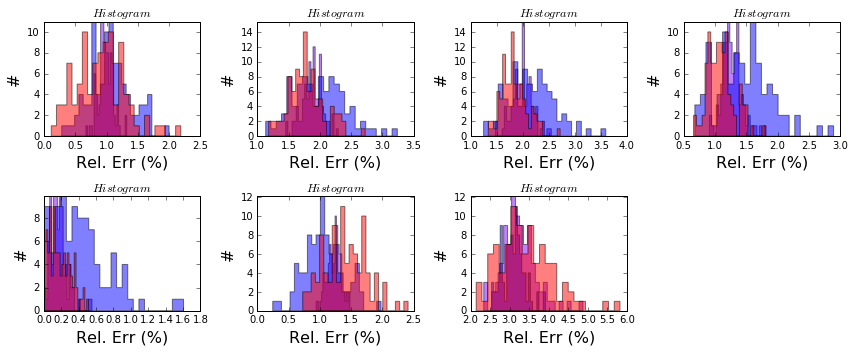

In [63]:
genIREs_tin_PTAT_100, errByTemp_tin_PTAT_100 = FIFitMCCorners(folderPath+'MCData/AH_MC_Simp_C1_1x_C2_1x_Iin2x_PTAT_100Ckts_1CS_Corners.csv',
        IScaleFactor='nA', FScaleFactor='MHz', cktPlotList=None, PTAT=True, corner='TT')
show()
print "Mean error by Iin at 20C(%):", mean(errByTemp_tin_PTAT_100[20], axis=0)*100
print "Mean error by Iin at 25C(%):", mean(errByTemp_tin_PTAT_100[25], axis=0)*100
print "Mean error by Iin at 30C(%):", mean(errByTemp_tin_PTAT_100[30], axis=0)*100
plotErrDistByTemp(errByTemp_tin_PTAT_100, numBins=25)


Using these params to fit the data
	Ch Params: [  2.63638461e-05   8.17012191e-05   4.28149788e+08   1.12197248e-07]
	Dch Params: [  1.70334604e-02  -4.18609825e-03  -3.62894782e+10  -8.49104052e-06]


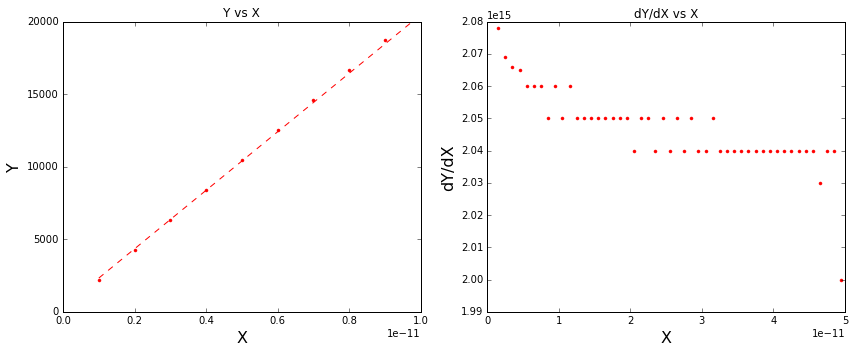

In [66]:
group = pd.read_csv(folderPath+'/MCData/AH_MC_Simp_C1_1x_C2_1x_Iin2x_CEl_LinSteps.csv')

IScaleFactor='nA'
FScaleFactor='MHz'

#print('Ckt: {}\tTemp: {}'.format(cktNum, curTemp))
#print(group.loc[:,['Iin','freqVout']])
curIins = array(group['Iin'])
curFs = array(group['freqVout'])

curTLs = array(group['TF4R5'])
curTEs = array(group['TF5R5'])
curTHs = array(group['TF6R5'])
curTchs, curTdchs = getPeriodLengths(curTLs, curTEs, curTHs)

#x_th, Fs_th, curFFitParams = getLinFitParams(curIins, curFs)
x_th, Tchs_th, curChFitParams = getNLFitParams(curIins, curTchs)
x_th, Tdchs_th, curDchFitParams = getNLFitParams(curIins, curTdchs)

subplot(1,2,1)
plotXY(curIins, curFs, xLims=(0,0.1e-10), yLims=(0,2e4))
Fs_th = 1./(Tchs_th+Tdchs_th)
plotXY(x_th, Fs_th, marker='', lineStyle='--')
subplot(1,2,2)
plotDeriv(curIins[:50], curFs[:50])
#plotFI(curIins, curFs, 25, x_th, Fs_th,
#       IScaleFactor=IScaleFactor, FScaleFactor=FScaleFactor)
tight_layout()

# Calculate the relative error in frequency or input current
print 
print "Using these params to fit the data"
#print "\tLin Fit Params:", curFFitParams
print "\tCh Params:", curChFitParams
print "\tDch Params:", curDchFitParams

#print "Residual Error with fit params from room temp"
#genParams = curFFitParams
#IREInfo = calcLinIRE(curIins, curFs, genParams, IScaleFactor=IScaleFactor, 
#                   printREbyIin=False, printRawData=False)
#avgRE, avgLogRE, REs, logREs, Is, thIs, logIs, logThIs = IREInfo

#genParams = curChFitParams, curDchFitParams
#Fs_th = 1./(Tchs_th+Tdchs_th)
#IREInfo = calcNLIRE(curIins, curFs, genParams, IScaleFactor=IScaleFactor, 
#                   printREbyIin=True, printRawData=False)
#genAvgIRE, genIREs, Is, thIs = IREInfo

Using fake data to see how well my fitting algorithm can recover my actual data.

	Ch Params: [  9.22404638e-09  -4.03892102e-07   3.52474975e+08   1.10152392e-07]
	Dch Params: [  6.57750954e-09   1.71246180e-07   5.03386729e+08   7.57241108e-08]


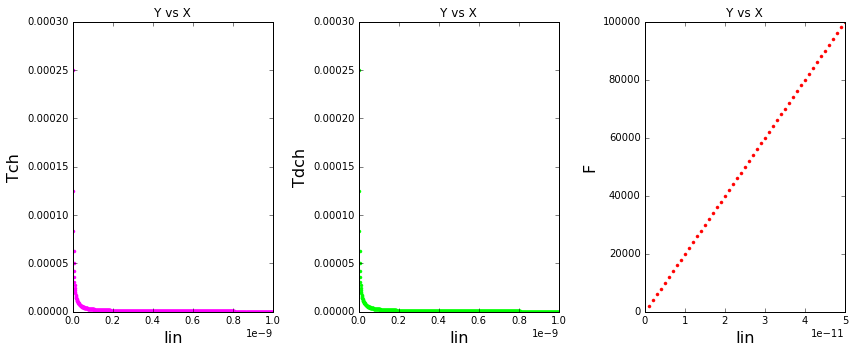

In [117]:
fakeIins = 1e-12*arange(1,1000)
fakeTchs = NLPeriod(fakeIins, (20e-9, -5.5e-7, 4.8e8, 15e-8))
fakeTdchs = NLPeriod(fakeIins, (10e-9, 5e-7, 14e8, 110e-8))
fakeFs = 1./(fakeTchs+fakeTdchs)

x_th, Tchs_th, curChFitParams = getNLFitParams(fakeIins, fakeTchs)
x_th, Tdchs_th, curDchFitParams = getNLFitParams(fakeIins, fakeTdchs)

print "\tCh Params:", curChFitParams
print "\tDch Params:", curDchFitParams

subplot(1,3,1)
plotXY(fakeIins, fakeTch, color=(1,0,1), xLbl='Iin', yLbl='Tch')
subplot(1,3,2)
plotXY(fakeIins, fakeTdch, color=(0,1,0), xLbl='Iin', yLbl='Tdch')
subplot(1,3,3)
plotXY(fakeIins[:50], fakeF[:50], xLbl='Iin', yLbl='F')
tight_layout()

Iins: [  1.00000000e-14   3.16200000e-14   1.00000000e-13   3.16200000e-13
   1.00000000e-12   3.16200000e-12   1.00000000e-11]
Max Error by Iin(%): [ 1.95698656  1.80201974  1.61874465  1.43027144  1.20341042  1.36258654
  2.10518559]
Mean Error by Iin(%): [ 0.87436654  0.58130086  0.64389559  0.59955679  0.40106627  0.43337595
  1.26373666]


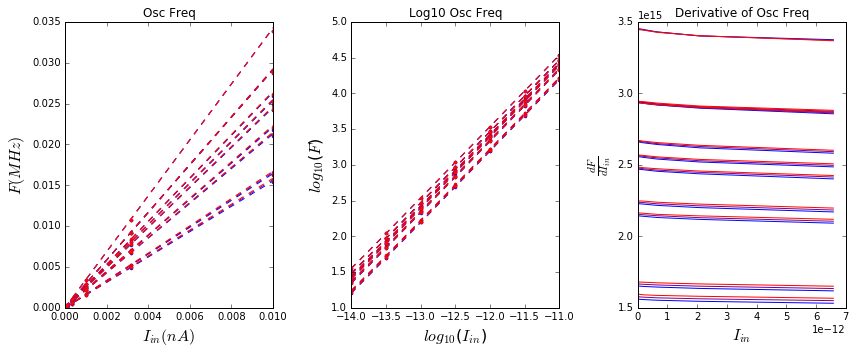

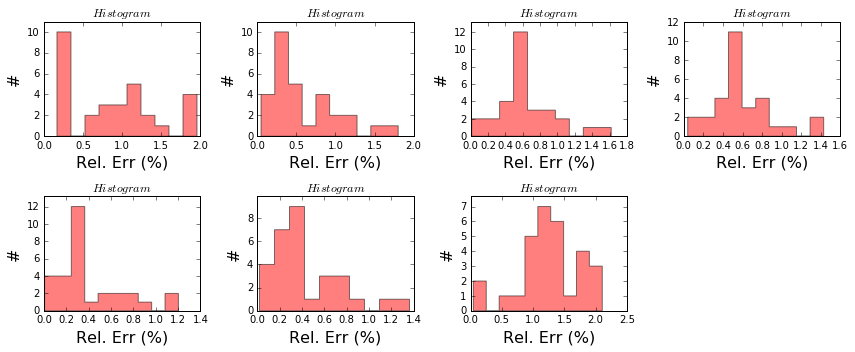

Mean error by Iin at 20C(%): [ 1.28627428  0.3201205   0.37983428  0.38054177  0.29424138  0.72239427
  1.74413739]
Mean error by Iin at 25C(%): [ 0.20756014  0.38894277  0.55490373  0.51149757  0.25660533  0.27332519
  1.24372522]
Mean error by Iin at 30C(%): [ 1.12926518  1.03483929  0.99694875  0.90663103  0.6523521   0.30440839
  0.80334738]


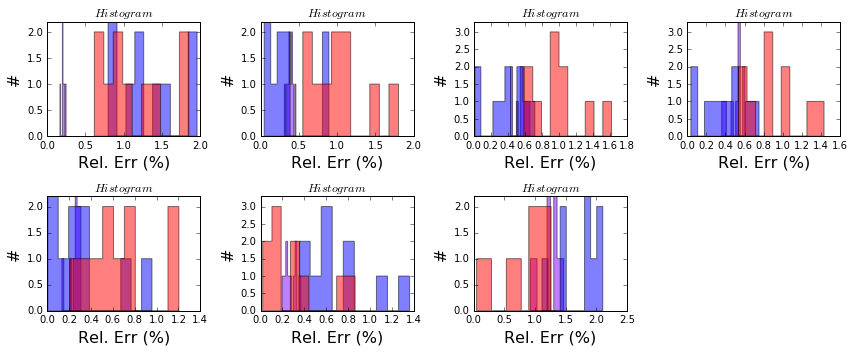

In [387]:
genIREs_eg_10Ckts, errByTemp_eg_10Ckts = FIFitLinMC(folderPath+'/MCData/AHeg_MC_KB_C1_1x_C2_3x_Iin2x_CEl_SepPeriods_10Ckts.csv',
        IScaleFactor='nA', FScaleFactor='MHz', cktPlotList=None)
show()
plotErrDist(genIREs_eg_10Ckts, numBins=10)
show()
print "Mean error by Iin at 20C(%):", mean(errByTemp_eg_10Ckts[20], axis=0)*100
print "Mean error by Iin at 25C(%):", mean(errByTemp_eg_10Ckts[25], axis=0)*100
print "Mean error by Iin at 30C(%):", mean(errByTemp_eg_10Ckts[30], axis=0)*100
plotErrDistByTemp(errByTemp_eg_10Ckts, numBins=10)

### Calc Error Functions

In [10]:
# Calculate the Relative RMSE of data compared to the fit
def calcRRMSE(data, dataTh, printRawData=False):
    SE = (data-dataTh)**2
    print "aver. error^2", mean(SE)
    resSampVar = sum(SE)/(len(SE)-1)
    RMS = sqrt(mean(dataTh**2))
    RRMSE = sqrt(resSampVar/RMS)
    if printRawData:
        print data, "\n", dataTh
        print "SE", SE
        print "Res Samp Variance", resSampVar
        print "RMS", RMS
        print 'Relative RMSE: {:%}'.format(RRMSE)
    return RRMSE

# Get the RRMSE values for both current and frequency based error measurements
def getRRMSEs(Iins, Fs, Params, IScaleFactor, printREbyIin=False, printRawData=False):
    avgFRE, avgLogFRE, Fs, thFs, logFs, logThFs = calcRE(Iins, Fs, Params, IScaleFactor, printREbyIin, printRawData)
    avgIRE, avgLogIRE, Is, thIs, logIs, logThIs = calcIRE(Iins, Fs, Params, IScaleFactor, printREbyIin, printRawData)
    FRRMSE = calcRRMSE(Fs, thFs, printRawData)
    IRRMSE = calcRRMSE(Is, thIs, printRawData)
    return FRRMSE, IRRMSE, avgFRE, avgLogFRE, avgIRE, avgLogIRE

# Calculate the Relative Error of data compared to a fit
def calcLinRE(Iins, Fs, Params, IScaleFactor, printREbyIin, printRawData=False):
    logThFs = log10F(Iins, Params)
    logFs = log10(Fs)
    avgLogRE, logREs = getAvgRE(logFs, logThFs)
    
    thFs = linF(Iins, Params)
    avgRE, REs = getAvgRE(Fs, thFs)
    if printRawData or printREbyIin:
        print "Relative Error in Frequency"
    if printRawData:
        print "Data Iins:", Iins
        print "Model Fs(log):", logThFs
        print "Data Fs(log):",logFs
        print "Model Fs(lin):", thFs
        print "Data Fs(lin):",Fs
    if printREbyIin:
        relErrbyIin(Iins, REs, logREs=logREs, IScaleFactor=IScaleFactor)
    return avgRE, avgLogRE, REs, logREs, Fs, thFs, logFs, logThFs

# Calculate the Relative Error for current (IRE) compared to a fit
def calcLinIRE(Iins, Fs, Params, IScaleFactor, printREbyIin, printRawData=False):
    logThIs = invLog10F(Fs, Params)
    logIs = log10(Iins)
    avgLogRE, logREs = getAvgRE(logIs, logThIs)
    
    thIs = invLinF(Fs, Params)
    Is = Iins
    avgRE, REs = getAvgRE(Is, thIs)
    
    if printRawData or printREbyIin:
        print "Relative Error in Input Current"
    if printRawData:
        print "Data Fs:", Fs
        print "Model Iins(log):", logThIs
        print "Data Iins(log):", logIs
        print "Model Iins(lin):", thIs
        print "Data Iins(lin):", Is    
    if printREbyIin:
        relErrbyIin(Iins, REs, logREs=logREs, IScaleFactor=IScaleFactor)
    return avgRE, avgLogRE, REs, logREs, Is, thIs, logIs, logThIs

# Calculate the Relative Error of data compared to a fit
def calcNLRE(Iins, Fs, Params, IScaleFactor, printREbyIin, printRawData=False):
    chParams, dchParams = Params
    thFs = NLF(Iins, chParams, dchParams)
    avgRE, REs = getAvgRE(Fs, thFs)
    if printRawData:
        print "Raw Data, between model and data"
        print "Data Iins:", Iins
        print "Model Fs:", thFs
        print "Data Fs:",Fs
    if printREbyIin:
        print "Relative Freq Error by Iin"
        relErrbyIin(Iins, REs, IScaleFactor=IScaleFactor)
    return avgRE, REs, Fs, thFs

# Calculate the Relative Error for current (IRE) compared to a fit
def calcNLIRE(Iins, Fs, Params, IScaleFactor, printREbyIin, printRawData=False):
    chParams, dchParams = Params
    # Solve for the input current in the model that gives the firing rate
    thIs = fsolve(NLFErr, Iins, (Fs, chParams, dchParams))
    avgRE, REs = getAvgRE(Iins, thIs)
    
    if printRawData:
        print "Raw Data, between model and data"
        print "Data Fs:", Fs
        print "Model Iins:", thIs
        print "Data Iins:", Iins    
    if printREbyIin:
        print "Relative Iin Error by Iin"
        relErrbyIin(Iins, REs, IScaleFactor=IScaleFactor)
    return avgRE, REs, Iins, thIs

def getAvgRE(data, dataTh):
    #print "Absolute Error: ", (data - dataTh)
    Es = data-dataTh
    REs = Es/dataTh
    avgRE = mean(abs(REs))
    return avgRE, REs

## Print Functions
These functions act as helper print functions for various things that need to be printed

In [11]:
def relErrbyIin(Iins, REs, logREs=None, IScaleFactor='pA'):
    IScale, ILbl = getIScaleVal(IScaleFactor)
    scIins = Iins/IScale
    if logREs==None:
        print '{:>5s}\t\t{:^12s}'.format("Iins", "Percent Error")
        for i, curIin in enumerate(Iins):
            print '{:>6.3f} {}\t{:^12.3%}'.format(scIins[i], IScaleFactor, REs[i])
    else:
        print '{:>5s}\t\t{:^12s}\t{:^12s}'.format("Iins", "% Error (lin)", "% Error (log)")
        for i, curIin in enumerate(Iins):
            print '{:>6.3f} {}\t{:^12.3%}\t{:^12.3%}'.format(scIins[i], IScaleFactor, REs[i], logREs[i])

# This function will print out the percentage of the overall period that is attributed to the inverter delay.
def percPeriodbyDelay(TsAsFuncOfIin, curIins, avgLoopDelay, curTemps):
    print 'Percent of overall period taken by delay from feedback buffer delay'
    print '{:>5s}\t\t'.format("Iins") + "%s"%'\t'.join(curTemps)
    for i, curTs in enumerate(TsAsFuncOfIin):
        #print mean(curTs), max(curTs), min(curTs), std(curTs), var(curTs)
        Iins_fA = curIins[i]/10**-15
        percDelay = avgLoopDelay*1e3/curTs
        foo = list()
        for i, curPDelay in enumerate(percDelay):
            #print '\t{:^6.3%}'.format(percDelay[i])
            foo.append('\t{:^6.3%}'.format(percDelay[i]))
        #print foo
        print '{:>5.0f} fA'.format(Iins_fA) + ''.join(foo)

# Calculate the percentage variance that results from the variation in temperature.
# curTemps: When a list of temperatures is passed in, this argument does two things
#    1) It is used as a flag to tell the function to print each periods 
#    deviation from the mean as a signed percentage of the mean.  (It only does this
#    if the number of curTemps is the same as the number of curTs)
#    2) It passes in the array of temperatures to print individual values corresponding
#    temperature 
def percVariancebyTemp(FsAsFuncOfIin, curIins, curTemps=None, IScaleFactor='pA'):
    IScale, ILbl = getIScaleVal(IScaleFactor)
    print 'Percent Variance at each Iin, as you vary temperature'
    if curTemps:
        print '{:>5s}\t\t{:^12s}'.format("Iins", "Percent Error(Negative values => Value smaller than mean)")
    else:
        print '{:>5s}\t\t{:^12s}'.format("Iins", "Percent Error")
    for i, curFs in enumerate(FsAsFuncOfIin):
        #print mean(curFs), max(curFs), min(curFs), std(curFs), var(curFs)
        scIins = curIins[i]/IScale
        RE = (max(curFs)-min(curFs))/mean(curFs)  # re = relative error
        print '{:>6.3f} {}\t{:^12.3%}'.format(scIins, IScaleFactor, RE)
        
        if curTemps and len(curTemps)==len(curFs):
            for j, curF in enumerate(curFs):
                IRE = (curF-mean(curFs))/mean(curFs)   # individual relative error
                print '\t{:>4.1f} C\t{:^12.3%}'.format(curTemps[j], IRE)

# Calculate the percentage variance that results from the variation in temperature.
# vals: matrix of dimensions (numIins x numTemps)
# idealVal: the ideal value you want to compare the measurements to
# curIins: array of Iin values (in Amps) of length numIins
# curTemps: array of temperature values (in C) of length numTemps
def percVarReltoIdeal(measVals,idealVal,curIins,curTemps, IScaleFactor):
    IScale, ILbl = getIScaleVal(IScaleFactor)
    print
    for i, curVals in enumerate(measVals):
        print '{:>5s}\t\t{:^2s}\t{:^12s}'.format("Iins", "Temp", "Percent Error")
        for j, curVal in enumerate(curVals[i]):
            scIins = curIins[i]/IScale
            re = (curVal-idealVal)/idealVal
            print '{:>6.3f} {}\t{:^2s}\t{:^12.3%}'.format(scIins, IScaleFactor, curTemps[j], re)
            

# ThinOxide FETs for Large Currents using Source Switches

Below, you will find the final results from AHOsc_Char for the large current sensing AH circuit.  This circuit was made using simple mirrors and ThinFET inverters.  There are three inverters, the first two to create the oscillating waveform and the third to act as the source switches.

These measurements were made without buffers controlling the gates of the current sources.  This sweep also includes sweeping over temperature, so that we can see how this AH circuit will operate, in it's non-ideal, but realistic, configuration.

To get a good idea of how well the fit approximates the data, we also want to calculate the RMSE of the data.  This will give us an idea of what to expect in the actual circuit when it is built.  We can see this in the "Relative RMSE" calculation, calculated using the calcRRMSE function.

The results below also quantify the percentage difference in the period as we sweep over temperatures for the AH circuit analyzed above.

The inverters are sized as shown below: 

    Thin PFET: 90n x 30n
    Thin NFET: 80n x 30n
   
Our circuit's requirements for large input currents (10pA to 10nA) is to be able to have a maximum period length of $20\mu s$ for the smallest input current and a <1% error in period measurements over $50^{\circ}C$.

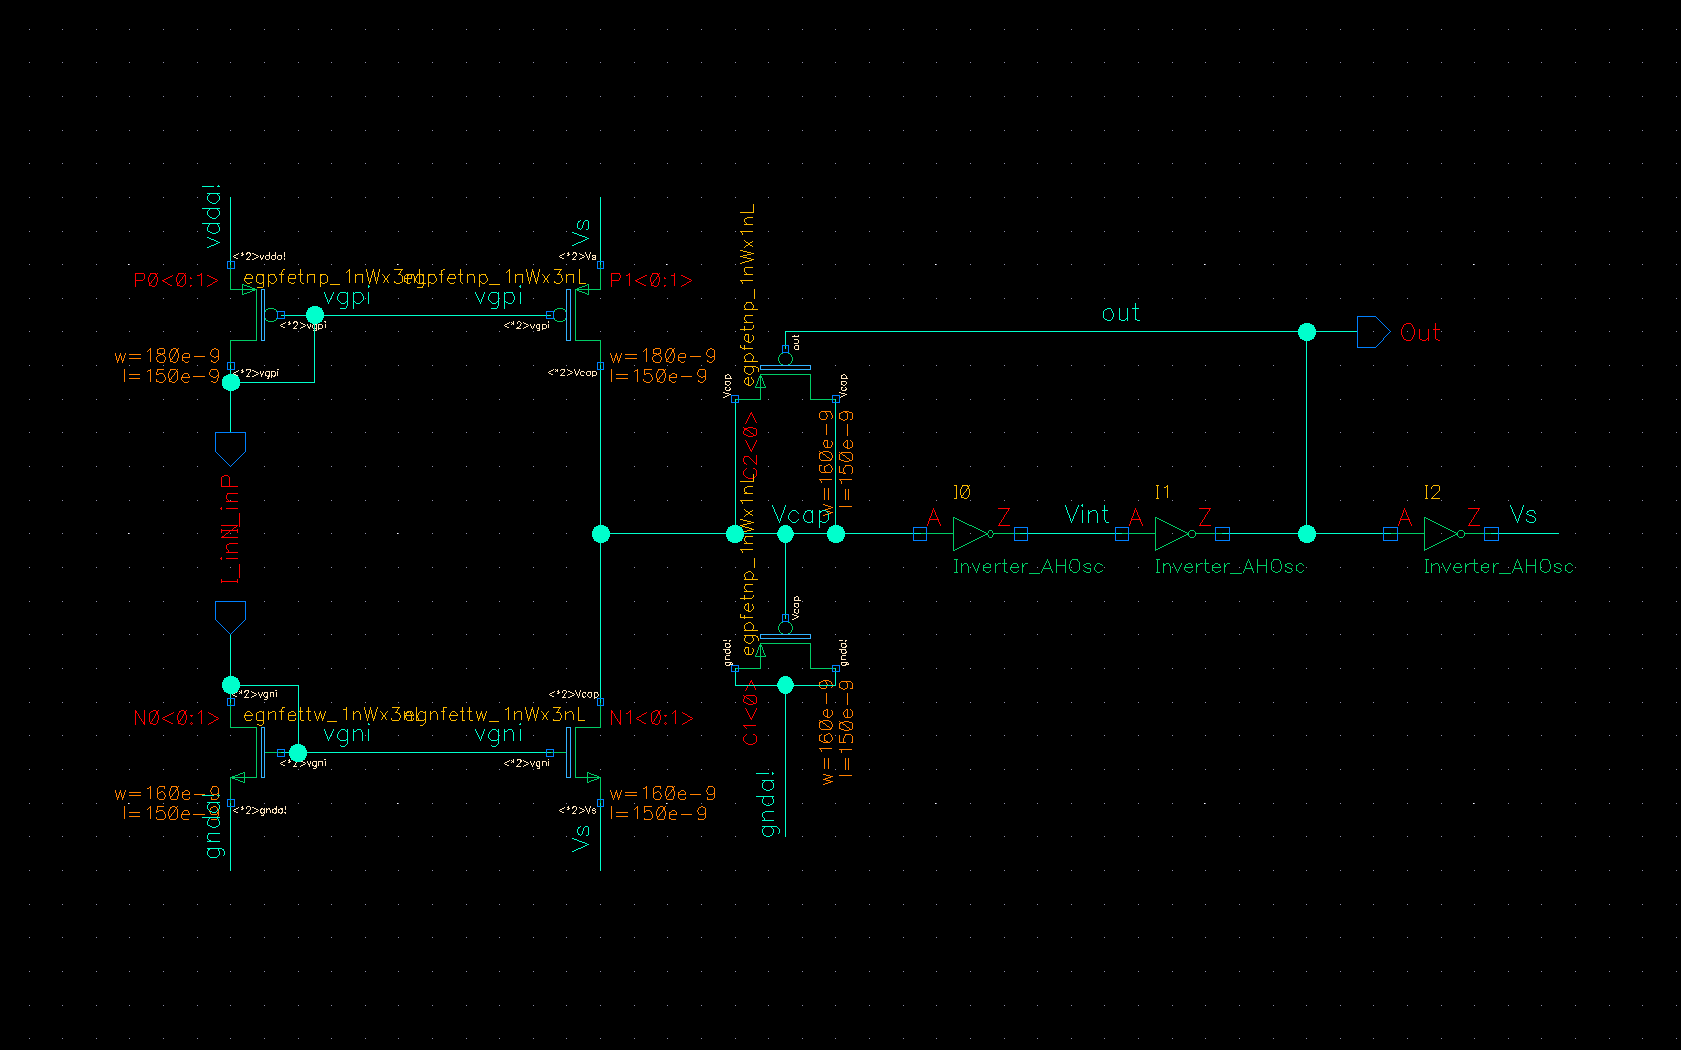

In [119]:
Image(folderPath + "AH_tin/AH_Simp_C1_1x_C2_1x_Iin1x_SwitchonSources.png", width=800)

## Iin 2x, C1 1x, C2 1x

### Sweep from 10pA to 10nA

Temps:  [20, 25, 30]
Iins:  [  1.00000000e-11   3.16227766e-11   1.00000000e-10   3.16227766e-10
   1.00000000e-09   3.16227766e-09   1.00000000e-08]
AH_tin/AH_Freq_Simp_Temp20C_C1_1x_C2_1x_Iin2x_SwitchonSource.csv
AH_tin/AH_Freq_Simp_Temp25C_C1_1x_C2_1x_Iin2x_SwitchonSource.csv
AH_tin/AH_Freq_Simp_Temp30C_C1_1x_C2_1x_Iin2x_SwitchonSource.csv

General Params: [  2.06695864e+15   5.31497944e-13]
Temp: 20-------------
Temp-Specific Params: [  2.06741982e+15   5.37668149e-13]
Relative Error in Frequency
 Iins		% Error (lin)	% Error (log)
 0.010 nA	  -0.774%   	  -0.078%   
 0.032 nA	   1.803%   	   0.161%   
 0.100 nA	   2.222%   	   0.180%   
 0.316 nA	   1.789%   	   0.132%   
 1.000 nA	   0.788%   	   0.054%   
 3.162 nA	  -1.005%   	  -0.064%   
10.000 nA	  -4.413%   	  -0.268%   
Relative Error in Input Current
 Iins		% Error (lin)	% Error (log)
 0.010 nA	   0.821%   	  -0.032%   
 0.032 nA	  -1.801%   	   0.075%   
 0.100 nA	  -2.185%   	   0.096%   
 0.316 nA	  -1.760%   	   0.081%

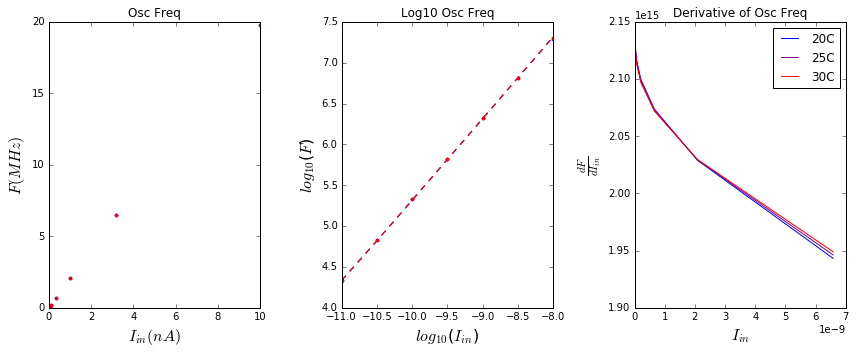

In [69]:
FIFit(paramFileName="SweptParams_20Cto30C_3Tsteps_10pAto10nA_7steps.csv", 
      dataFileNamePrefix="AH_tin/AH_Freq_Simp_Temp",
      dataFileNameSuffix="C_C1_1x_C2_1x_Iin2x_SwitchonSource.csv",
      IScaleFactor='nA', FScaleFactor='MHz')

### Sweep from 1pA to 1nA

Temps:  [20, 25, 30]
Iins:  [  1.00000000e-12   3.16227766e-12   1.00000000e-11   3.16227766e-11
   1.00000000e-10   3.16227766e-10   1.00000000e-09]
AH_tin/AH_Freq_Simp_Temp20C_C1_1x_C2_1x_Iin2x_SwitchonSource_1pAto1nA.csv
AH_tin/AH_Freq_Simp_Temp25C_C1_1x_C2_1x_Iin2x_SwitchonSource_1pAto1nA.csv
AH_tin/AH_Freq_Simp_Temp30C_C1_1x_C2_1x_Iin2x_SwitchonSource_1pAto1nA.csv

General Params: [  2.11810168e+15   8.96733914e-14]
Temp: 20-------------
Temp-Specific Params: [  2.11968617e+15   8.75515995e-14]
Relative Error in Frequency
 Iins		% Error (lin)	% Error (log)
 0.001 nA	  -0.566%   	  -0.073%   
 0.003 nA	   0.966%   	   0.109%   
 0.010 nA	   1.071%   	   0.107%   
 0.032 nA	   0.729%   	   0.065%   
 0.100 nA	   0.194%   	   0.016%   
 0.316 nA	  -0.530%   	  -0.040%   
 1.000 nA	  -1.603%   	  -0.111%   
Relative Error in Input Current
 Iins		% Error (lin)	% Error (log)
 0.001 nA	   0.621%   	  -0.022%   
 0.003 nA	  -0.983%   	   0.037%   
 0.010 nA	  -1.069%   	   0.042%   
 0.03

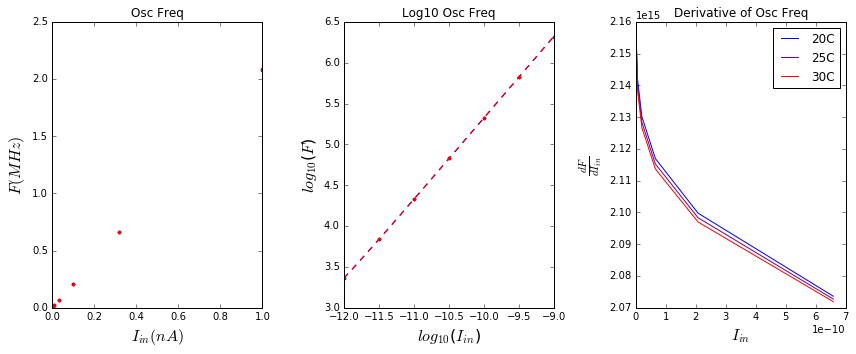

In [70]:
FIFit(paramFileName="SweptParams_20Cto30C_3Tsteps_1pAto1nA_7steps.csv", 
       dataFileNamePrefix="AH_tin/AH_Freq_Simp_Temp",
       dataFileNameSuffix="C_C1_1x_C2_1x_Iin2x_SwitchonSource_1pAto1nA.csv",
      IScaleFactor='nA', FScaleFactor='MHz')

This design is the "winner" for the thin-oxide/large current form of the ADC.  We can simulate from 1pA to 10nA with minimal temperature variance and with speeds fast enough to handle the synapse output.  The synapse output will vary from 1pA to 100pA and needs to be sampled at least every 2 ms (>500MHz).  If we set the reference current to 1pA, we can sample every ~450us or at a sampling rate of 2.2kHz.

# ThickOxide Inverter for Slow Input Currents

For smaller currents, we found in AHOsc_Char that we can change the inverters, in the feedback chain of inverters, to ThickFET transistors.  The reason we think we can get away with using ThickFETs for smaller currents is because the inverter's gain will still be much faster than the capacitor's charging speed, and as such the non-linearity introduced by the ThickFET will be a much smaller proportion of the switching time of the oscillator.  The sweep will range from 10fA to 10pA (to cover the remaining 2 orders of magnitude).

In this section we compare two biasing circuits (to set the "current source" values).  We are going to investigate Kwabena's Mirror (previously known as the Vcap-based biasing) compared to Ben's Mirror.  We want to analyze these mirrors in more detail to find out which one behaves more ideally over temperature for our input currents.  If we are able to do this, then we will have a better understanding of where our problems are coming from and will therefore be able to make a more informed decision regarding which architecture to use (assuming we can optimize the speeds further).

_Note: To speed up simulation time, I am going to continue to do abridged sweeps of temperatures and $I_{in}$.  Temperature will be swept from $0^{\circ}C-50^{\circ}C$ in 3 equal steps, and input current will have 5 logarithmic steps from 100fA to 10pA._

Our circuit's requirements for small input currents (100fA to 10pA) is to be able to have a maximum period length of 1ms for the smallest input current and a <1% error in period measurements over $50^{\circ}C$.

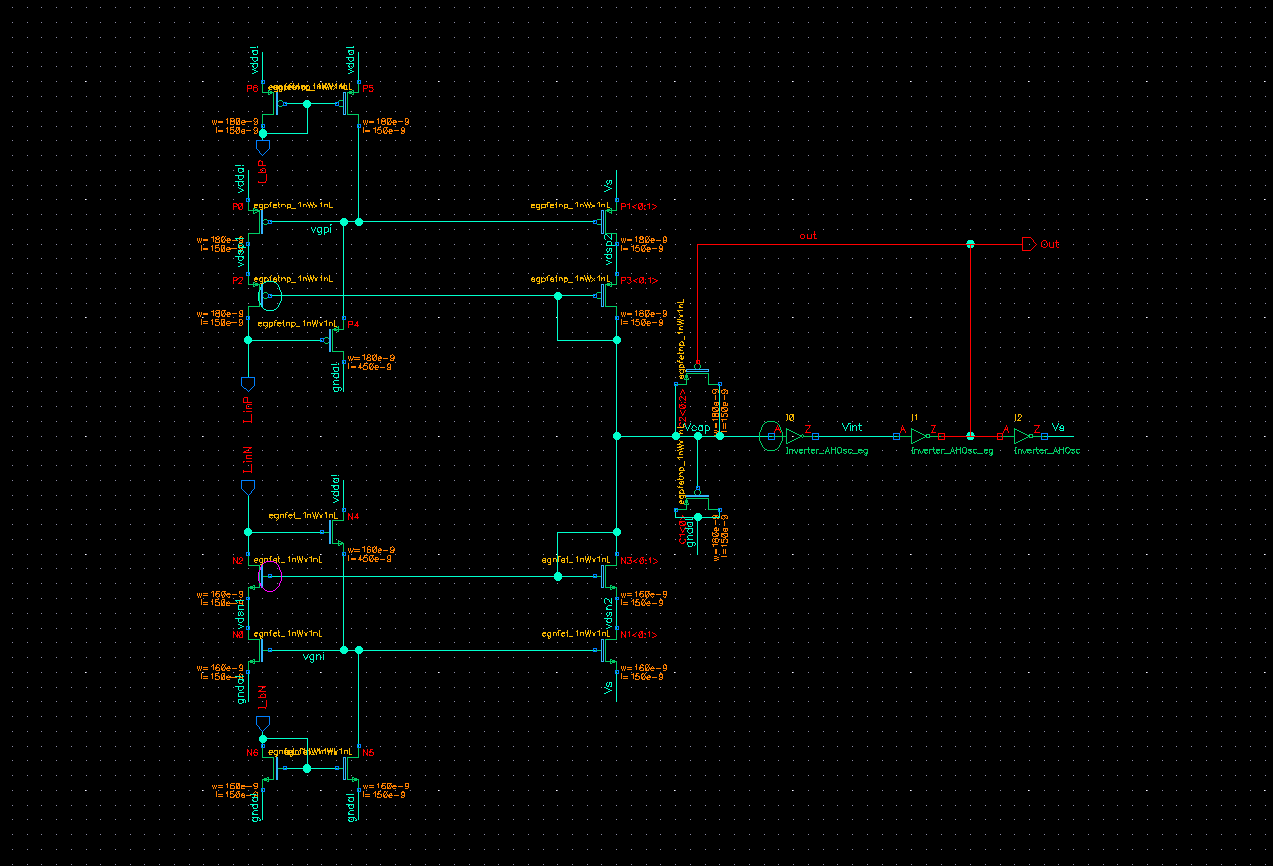

In [14]:
Image(folderPath + "AH_eg/AHeg_KB_C1_1x_C2_3x_Iin2x.png", width=800)

# Monte Carlo Simulations

## ThinFET Iin 2x, C1 1x, C2 1x, 1pA to 1nA

In this section I post my results from performing Monte Carlo simulations on the thin-FET AH circuit.

### Tin No C-element


Iins: [  1.00000000e-12   3.16200000e-12   1.00000000e-11   3.16200000e-11
   1.00000000e-10   3.16200000e-10   1.00000000e-09]
Max Error by Iin(%): [ 0.87652806  1.20545553  1.32196062  0.97872547  0.37082575  0.82536583
  2.20771085]
Mean Error by Iin(%): [ 0.48655378  0.97232717  1.00031377  0.65261354  0.11964657  0.59655352
  1.67939729]


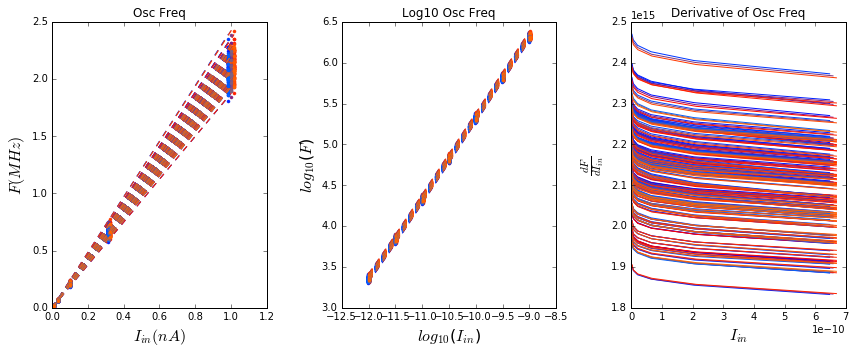

Mean error by Iin at 20C(%): [ 0.68026217  0.96862294  1.05828811  0.72990166  0.19920425  0.51576416
  1.61203742]
Mean error by Iin at 25C(%): [ 0.48817633  0.9702226   0.99822061  0.65079471  0.1102107   0.59895341
  1.68164908]
Mean error by Iin at 30C(%): [ 0.29122283  0.97813596  0.94443258  0.57714427  0.04952477  0.674943
  1.74450538]


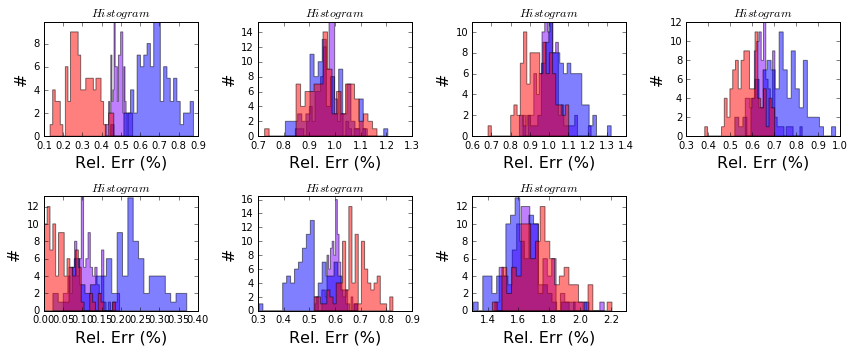

In [28]:
genIREs_tin_PTAT_100, errByTemp_tin_PTAT_100 = FIFitMC(folderPath+'MCData/AH_MC_Simp_C1_1x_C2_1x_Iin2x_PTAT_100Ckts.csv',
        IScaleFactor='nA', FScaleFactor='MHz', cktPlotList=None, PTAT=True)
show()
print "Mean error by Iin at 20C(%):", mean(errByTemp_tin_PTAT_100[20], axis=0)*100
print "Mean error by Iin at 25C(%):", mean(errByTemp_tin_PTAT_100[25], axis=0)*100
print "Mean error by Iin at 30C(%):", mean(errByTemp_tin_PTAT_100[30], axis=0)*100
plotErrDistByTemp(errByTemp_tin_PTAT_100, numBins=25)

### Tin No C-element with Monte Carlo analysis over 3 Corners (SS, FF, TT)

The results below now take the same measurements as above but with two changes.  The first change is that this now includes other corners (FF, SS, TT).  The second change is that the circuit now accepts only one current input and innate mirrors that current to both the NFET and PFET mirrors.

Cur Corner:  TT

Iins: [  1.00000000e-12   3.16200000e-12   1.00000000e-11   3.16200000e-11
   1.00000000e-10   3.16200000e-10   1.00000000e-09]
Max Error by Iin(%): [ 2.18685675  3.23875472  3.59329701  2.89300051  1.60608394  2.41013752
  5.82132932]
Mean Error by Iin(%): [ 0.98197273  1.88822143  1.99556797  1.270558    0.26010118  1.2348212
  3.2544467 ]


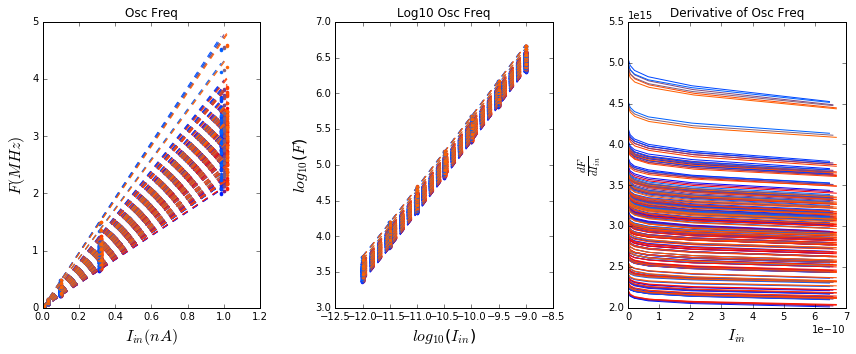

Mean error by Iin at 20C(%): [ 1.06154959  1.99639849  2.15658026  1.44836065  0.42784353  1.06182499
  3.09754187]
Mean error by Iin at 25C(%): [ 0.98340784  1.88305256  1.99545614  1.26876629  0.1694123   1.23320391
  3.25311374]
Mean error by Iin at 30C(%): [ 0.90096075  1.78521324  1.83466749  1.09454707  0.18304771  1.4094347
  3.41268448]


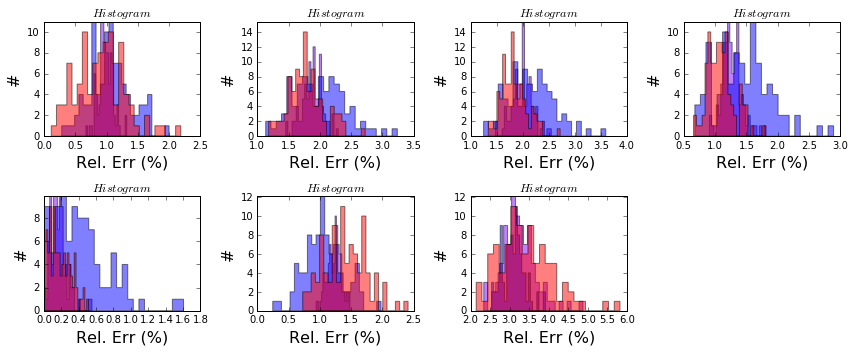

Cur Corner:  SS

Iins: [  1.00000000e-12   3.16200000e-12   1.00000000e-11   3.16200000e-11
   1.00000000e-10   3.16200000e-10   1.00000000e-09]
Max Error by Iin(%): [ 2.12006617  3.44393247  3.77597364  3.08068618  1.74693825  2.43539767
  6.32787106]
Mean Error by Iin(%): [ 0.92787664  1.84200702  1.99218146  1.31242743  0.29555793  1.20378651
  3.39442941]


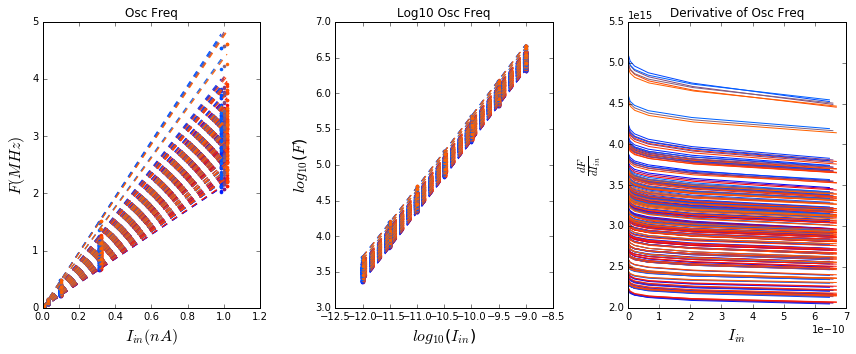

Mean error by Iin at 20C(%): [ 1.06154959  1.99639849  2.15658026  1.44836065  0.42784353  1.06182499
  3.09754187]
Mean error by Iin at 25C(%): [ 0.98340784  1.88305256  1.99545614  1.26876629  0.1694123   1.23320391
  3.25311374]
Mean error by Iin at 30C(%): [ 0.90096075  1.78521324  1.83466749  1.09454707  0.18304771  1.4094347
  3.41268448]


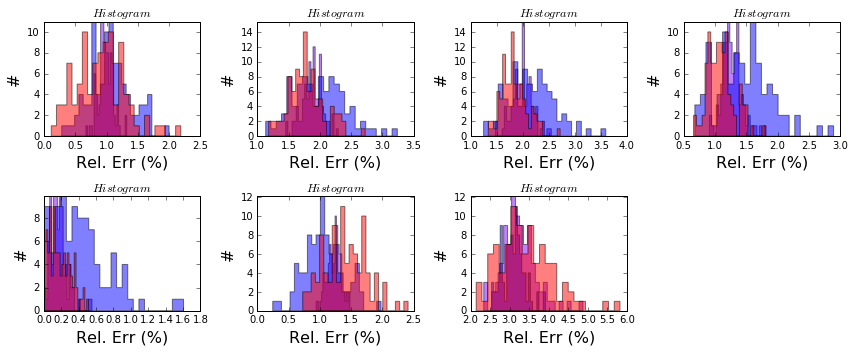

Cur Corner:  FF

Iins: [  1.00000000e-12   3.16200000e-12   1.00000000e-11   3.16200000e-11
   1.00000000e-10   3.16200000e-10   1.00000000e-09]
Max Error by Iin(%): [ 2.5128672   3.25616062  3.53607654  2.77455213  1.50973327  2.40084739
  5.55998357]
Mean Error by Iin(%): [ 1.10709192  2.03906852  2.06267925  1.265936    0.23082817  1.29499283
  3.23235497]


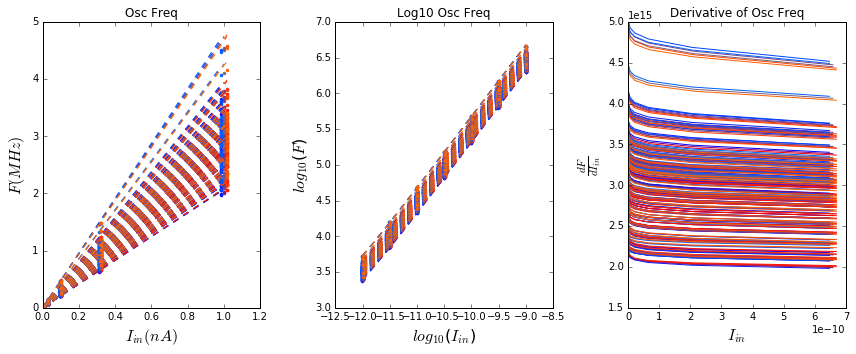

Mean error by Iin at 20C(%): [ 1.06154959  1.99639849  2.15658026  1.44836065  0.42784353  1.06182499
  3.09754187]
Mean error by Iin at 25C(%): [ 0.98340784  1.88305256  1.99545614  1.26876629  0.1694123   1.23320391
  3.25311374]
Mean error by Iin at 30C(%): [ 0.90096075  1.78521324  1.83466749  1.09454707  0.18304771  1.4094347
  3.41268448]


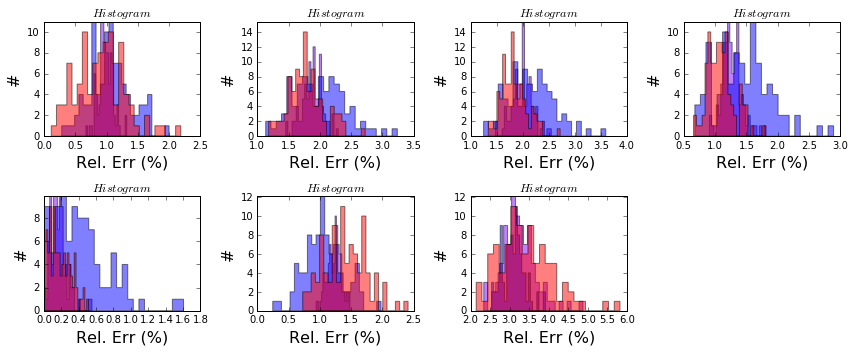

In [65]:
for curCorner in ['TT','SS','FF']:
    genIREs_tin_PTAT_10, errByTemp_tin_PTAT_10 = FIFitMCCorners(
        folderPath+'MCData/AH_MC_Simp_C1_1x_C2_1x_Iin2x_PTAT_100Ckts_1CS_Corners.csv',
            IScaleFactor='nA', FScaleFactor='MHz', cktPlotList=None, PTAT=True, corner=curCorner)
    show()
    print "Mean error by Iin at 20C(%):", mean(errByTemp_tin_PTAT_100[20], axis=0)*100
    print "Mean error by Iin at 25C(%):", mean(errByTemp_tin_PTAT_100[25], axis=0)*100
    print "Mean error by Iin at 30C(%):", mean(errByTemp_tin_PTAT_100[30], axis=0)*100
    plotErrDistByTemp(errByTemp_tin_PTAT_100, numBins=25)
    show()

## ThickFET Iin 2x, C1 1x, C2 3x, 10fA to 10nA

### EG No C-element


Iins: [  1.00000000e-14   3.16200000e-14   1.00000000e-13   3.16200000e-13
   1.00000000e-12   3.16200000e-12   1.00000000e-11]
Max Error by Iin(%): [ 2.41553693  1.39142608  1.17489356  1.16277549  0.96021526  1.08870441
  1.70253461]
Mean Error by Iin(%): [ 0.55998801  0.34170679  0.37274929  0.35306186  0.24765575  0.24416302
  0.73981222]


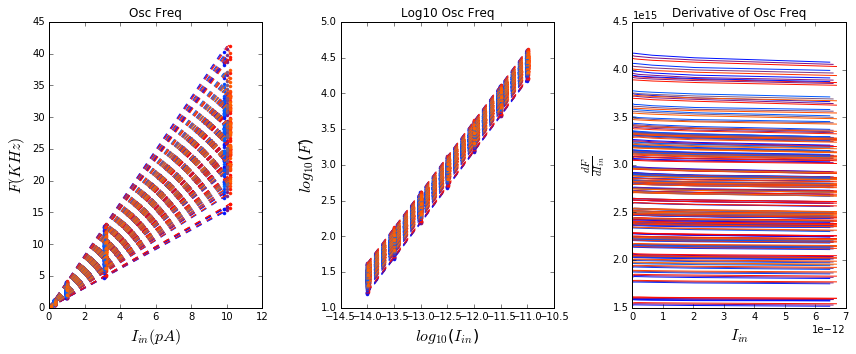

Mean error by Iin at 20C(%): [ 0.77098001  0.35589257  0.4199454   0.41853679  0.32238194  0.2636098
  0.74126605]
Mean error by Iin at 25C(%): [ 0.11662003  0.20849409  0.31892106  0.3074579   0.16011542  0.15631165
  0.73061262]
Mean error by Iin at 30C(%): [ 0.79236398  0.46073369  0.37938141  0.33319091  0.26046989  0.31256761
  0.74755799]


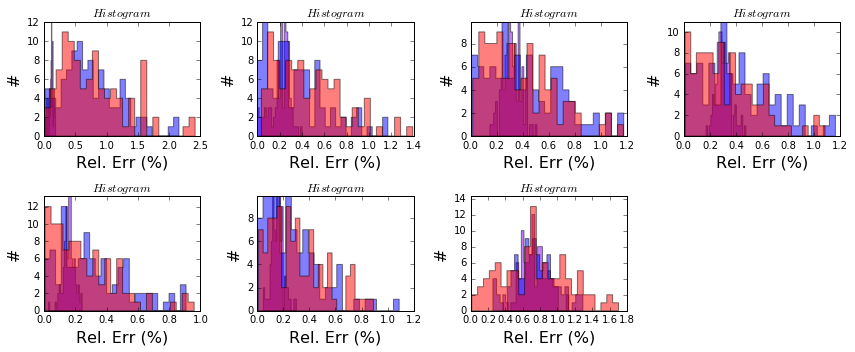

In [27]:
genIREs_eg_PTAT_100, errByTemp_eg_PTAT_100 = FIFitMC(folderPath+'/MCData/AHeg_MC_KB_C1_1x_C2_3x_Iin2x_PTAT_100Ckts.csv',
                                              IScaleFactor='pA', FScaleFactor='KHz', PTAT=True)
show()
print "Mean error by Iin at 20C(%):", mean(errByTemp_eg_PTAT_100[20], axis=0)*100
print "Mean error by Iin at 25C(%):", mean(errByTemp_eg_PTAT_100[25], axis=0)*100
print "Mean error by Iin at 30C(%):", mean(errByTemp_eg_PTAT_100[30], axis=0)*100
plotErrDistByTemp(errByTemp_eg_PTAT_100, numBins=25)

# Appendix
In this section are some other tests that I performed along the way

## Pandas Sandbox

In [43]:
MC_df = pd.read_csv(folderPath+'/MCData/AH_MC_Simp_C1_1x_C2_1x_Iin2x_PTAT_10Ckts_1CS_Corners.csv')
print MC_df.head(5)
print MC_df[MC_df.Iin==1e-12]
freqSeries = MC_df[MC_df.Iin==1e-12].freqVout

print array(freqSeries)
#hist(freqSeries, bins=100)
print freqSeries
print MC_df[0:2]
print MC_df['Point'].value_counts()* max(MC_df['Point'])
print len(MC_df)
print "Howdy"
print MC_df[MC_df['Corner'].str.contains('TT')]

   Point Corner           Iin    t_stop  temperature  freqVout     TF4R5  \
0      1   SS_0  1.000000e-12  0.005000           20      3107 -0.000461   
1      1   SS_1  1.000000e-12  0.005000           25      3158 -0.000454   
2      1   SS_2  1.000000e-12  0.005000           30      3209 -0.000447   
3      1   SS_3  3.162000e-12  0.001581           20      9564 -0.000150   
4      1   SS_4  3.162000e-12  0.001581           25      9719 -0.000148   

      TF5R5     TF6R5  
0 -0.000139  0.000183  
1 -0.000137  0.000179  
2 -0.000135  0.000176  
3 -0.000045  0.000059  
4 -0.000045  0.000058  
     Point Corner           Iin  t_stop  temperature  freqVout     TF4R5  \
0        1   SS_0  1.000000e-12   0.005           20      3107 -0.000461   
1        1   SS_1  1.000000e-12   0.005           25      3158 -0.000454   
2        1   SS_2  1.000000e-12   0.005           30      3209 -0.000447   
21       1   TT_0  1.000000e-12   0.005           20      3124 -0.000459   
22       1   TT_1  